[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Cl4ryty/synaptic_plasticity/blob/separated_data_loading/mnist_model_demo.ipynb)

# Replication study: Bio-inspired digit recognition using reward-modulated spike-timing-dependent plasticity in deep convolutional networks

---
**Group 7:** Krishnedu Bose, Alexander Ditz, Hannah Köster, Tim Kapferer, Hanna Willkomm

In this notebook, we'll guide you through the process of using our model and the steps involved in running it. Our goal is to demonstrate how our network classifies MNIST digits.

First, we need to load all the necessary libraries to run the model. Ensure that all required libraries are installed. If any are missing, please refer to the installation guide in our README.

## Setting up in colab (skip this if running locally)

In [ ]:
# clone the repository
!wget https://github.com/Cl4ryty/synaptic_plasticity/archive/refs/heads/main.zip
!unzip main.zip

In [ ]:
# install requirements
!pip install -r /content/synaptic_plasticity-main/requirements.txt

In [1]:
src_dir = '/content/synaptic_plasticity-main/src'

## Imports

In [2]:
%%capture
# Imports
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import spikingjelly
from spikingjelly.activation_based import functional
import tonic
import tonic.transforms as tonic_transforms
from IPython.display import HTML

**Important:** Provide the absolute path to the 'src' folder in the 'synaptic_plasticity' directory. This is not necessary when using colab, do not run this cell in that case (or you will have to rerun the corresponding cell for colab (see section above) again

In [ ]:
src_dir = '/Users/user_example/synaptic_plasticity/src'

In [3]:
# local imports of our code
os.chdir(src_dir)

import utils
import network
import plotting

## Loading a random MNIST image
Now, let's visualize a static MNIST digit by selecting a random sample from the MNIST testing dataset. First, we need to load the MNIST dataset and set up the DataLoader. Note that this process may take some time if the dataset hasn't been downloaded yet.

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist, batch_size=1, shuffle=True)

Below, we select a random sample from the MNIST test dataset and visualize it.

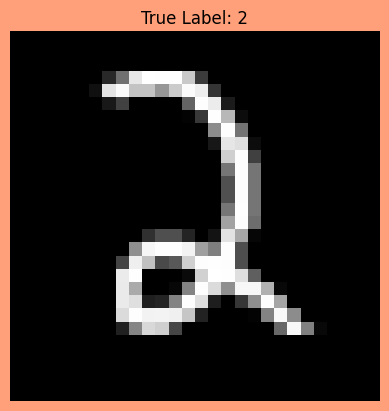

In [5]:
# Select a random sample
sample_idx = random.randint(0, len(mnist) - 1)
sample, label = mnist[sample_idx]

# Visualize the sample
plt.imshow(sample.squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"True Label: {label}")
plt.gcf().set_facecolor('lightsalmon')
plt.show()

## Encoding static image into spike trains

Since our network is composed of spiking neurons that integrate input over time, we can't simply feed a static sample into the network. We need to encode it into spike trains by introducing an additional temporal dimension. To achieve this, we'll use the `load_MNIST` function from `utils.py`, which transforms the data accordingly. If you're interested in the details of the transformation, check out the respective docstring for more information.

We'll use the `sample_idx` variable from above to ensure that the same random MNIST sample is selected.

In [6]:
%%capture
_, testing_loader = utils.load_MNIST()
encoded, encoded_label = testing_loader.dataset[sample_idx]

The input to the network consists of six channels. The following cell will visualize the spike trains for each channel based on our selected sample.

In [7]:
# Convert to numpy array for plotting
data_np = encoded.numpy()

# Create a figure and subplots
fig, axs = plt.subplots(1, 6, figsize=(18, 3))
fig.patch.set_facecolor('lightsalmon')

# Hide the axes for a cleaner look
for ax in axs:
    ax.axis('off')

# Animation update function
def update(t):
    for i, ax in enumerate(axs):
        ax.imshow(data_np[t, i], cmap='gray')
        ax.set_title(f'Channel = {i}', color='white', fontsize=10, fontweight='bold')
    return axs

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=15, interval=200, blit=False)

# Close the figure to prevent the initial plot from showing
plt.close(fig)

# Display the animation
HTML(ani.to_jshtml())

## Insert the encoded MNIST sample into the model
Now, we need to initialize our network to feed in the sample.

In [8]:
net = network.Network(number_of_classes=10)

As an example, let's visualize the first kernel of the convolutional layer.

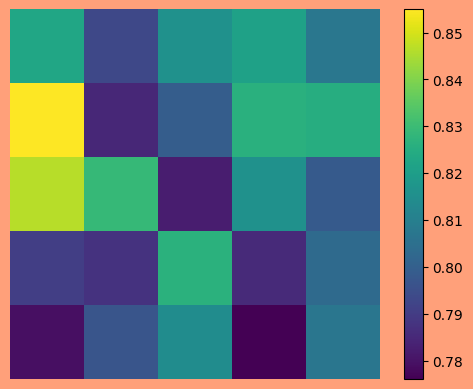

In [9]:
plt.imshow(net.conv1.weight.detach().numpy()[0,0])
plt.axis('off')
plt.colorbar()
plt.gcf().set_facecolor('lightsalmon')
plt.show()

Initially, the weights are set with a mean of 0.8 and a standard deviation of 0.02. As indicated by the colorbar, the weights appear to be untrained currently, as they are all approximately 0.8.

Let's use the `get_latest_checkpoint` function in `utils.py` to retrieve the most recent checkpoint from the training and the `load_checkpoint` function to load it.

In [10]:
latest_checkpoint_path = utils.get_latest_checkpoint('../checkpoints/experiment_1')
if latest_checkpoint_path:
    # Load the checkpoint if found
    start_epoch, training_layer = utils.load_checkpoint(net,
                                                    latest_checkpoint_path)

Latest checkpoint found: checkpoint_20240829-082540_epoch_39.pth
Checkpoint loaded: epoch 40, training layer 3.


Run the next cell to see how the weights have changed after training.

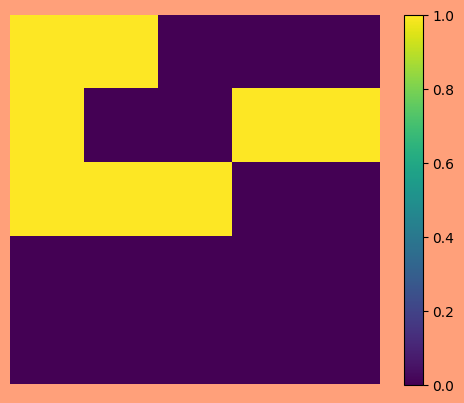

In [11]:
plt.imshow(net.conv1.weight.detach().numpy()[0,0])
plt.axis('off')
plt.gcf().set_facecolor('lightsalmon')
plt.colorbar()
plt.show()

Finally, let's feed our sample into the network.

In [12]:
# Set the network to multistep mode
functional.set_step_mode(net, step_mode='m')

# Prepare the input data for the network
frame = encoded.to('cpu:0')  # Move data to CPU
frame = frame.unsqueeze(dim=0)  # Add a batch dimension
frame = frame.transpose(0, 1)  # Transpose dimensions as needed by the network
frame = frame.float()  # Ensure data is float

# Pass the prepared input through the network
_ = net(frame)

Now it’s time to determine if the network can correctly classify our input sample. Press 'Run All' to quickly test another sample.

In [13]:
# Extract the decision value as an integer
decision = net.get_decision()
decision_value = int(decision.numpy()[0])

# Determine if the decision is correct
result = "Correct 😀" if decision_value == label else "Incorrect 😭"

# Print the result
print(f"The network decided: {decision_value}\nThe true label: {label}\n{result}")

The network decided: 2
The true label: 2
Correct 😀


## Loading a random N-MNIST sample

Now let’s apply the same process to the N-MNIST dataset, which is a spiking version of the frame-based MNIST dataset.

In [14]:
# Load the N-MNIST dataset
n_mnist = tonic.datasets.NMNIST(save_to='./data_n_mnist', train=False)
# Create DataLoader for training and testing
n_mnist_loader = DataLoader(n_mnist, batch_size=1, shuffle=True)

This cell visualizes a random sample from the N-MNIST test dataset. You can adjust `n_time_bins` (third line) to change the number of bins used to accumulate the spiking events. The two channels represent ON and OFF events: the ON channel captures spikes when the pixel intensity increases (i.e., when the image gets brighter), while the OFF channel captures spikes when the pixel intensity decreases (i.e., when the image gets darker).

In [15]:
# Define the transform
sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = tonic_transforms.ToFrame(sensor_size=sensor_size, n_time_bins=15)

# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  # 2 channels (ON/OFF)
fig.patch.set_facecolor('lightsalmon')

# Hide the axes for a cleaner display
for ax in axs:
    ax.axis('off')

# Select a random sample
sample_idx = random.randint(0, len(n_mnist) - 1)
sample_spiking, label_spiking = n_mnist[sample_idx]
# Debugging: Print sample index and label
print(f"Sample Index: {sample_idx}, Label: {label_spiking}")

# Apply the transform to the sample
def apply_transform(events, transform):
    frames = transform(events)
    return frames

frames = apply_transform(sample_spiking, frame_transform)

# Animation update function
def update(t):
    for i, ax in enumerate(axs):
        ax.imshow(frames[t, i], cmap='gray')  # Show the ON and OFF channels separately
        if i == 0:
            ax.set_title(f'ON Channel', color='white', fontsize=10, fontweight='bold')
        else:
            ax.set_title(f'OFF Channel', color='white', fontsize=10, fontweight='bold')
    return axs

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=frames.shape[0], interval=200, blit=False)

# Close the figure to prevent the initial plot from showing
plt.close(fig)

# Display the animation
HTML(ani.to_jshtml())

Sample Index: 1709, Label: 1


## Load N-MNIST from utils
Now we load the N-MNIST dataset using `load_NMNIST()` from `utils.py`, which applies transformations including denoising, a high refractory period to limit events to one per pixel, and conversion to frames with a time window that aligns with the time steps of the encoded MNIST.

Once again, we use the `sample_idx` variable to ensure we select the same sample from above.

In [16]:
%%capture
_, nmnist_encoded =  utils.load_NMNIST()
nmnist_sample, nmnist_label = nmnist_encoded.dataset[sample_idx]

The following cell will visualize the input to our model.

In [17]:
# Check the number of frames available
num_frames = data_np.shape[0]  # Assuming data_np has shape (num_frames, channels, height, width)

# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  # 2 channels (ON/OFF)
fig.patch.set_facecolor('lightsalmon')

# Hide the axes for a cleaner display
for ax in axs:
    ax.axis('off')

# Animation update function
def update(t):
    for i, ax in enumerate(axs):
        ax.imshow(nmnist_sample[t, i], cmap='gray')  # Show the ON and OFF channels separately
        ax.set_title(f'Channel = {i}', color='white', fontsize=10, fontweight='bold')
    return axs

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=nmnist_sample.shape[0], interval=200, blit=False)

# Close the figure to prevent the initial plot from showing
plt.close(fig)

# Display the animation
HTML(ani.to_jshtml())

## Insert the N-MNIST sample into the model
Let's initialize the network. It's important to set the number of input channels to two, as the N-MNIST dataset contains only two channels.

In [18]:
net = network.Network(input_channels=2, number_of_classes=10)

Don't forget to load the trained model.

In [19]:
latest_checkpoint_path = utils.get_latest_checkpoint('../checkpoints/experiment_2')
if latest_checkpoint_path:
    # Load the checkpoint if found
    start_epoch, training_layer = utils.load_checkpoint(net,
                                                    latest_checkpoint_path)

Latest checkpoint found: checkpoint_20240831-080532_epoch_20.pth
Checkpoint loaded: epoch 21, training layer 3.


Let's confirm by examining some of the weights.

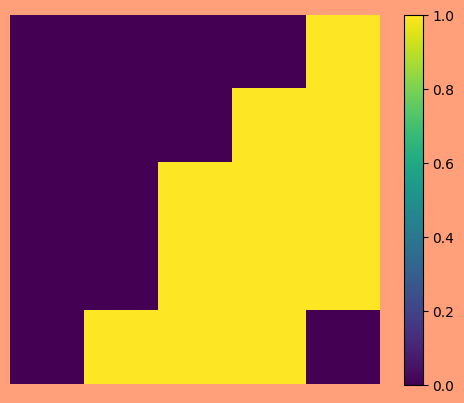

In [20]:
plt.imshow(net.conv1.weight.detach().numpy()[0,0])
plt.axis('off')
plt.gcf().set_facecolor('lightsalmon')
plt.colorbar()
plt.show()

Let's check if the network can correctly classify the sample.

In [21]:
functional.set_step_mode(net, step_mode='m')

frame = torch.tensor(nmnist_sample)
frame = frame.to('cpu:0')
frame = frame.unsqueeze(dim=0)
frame = frame.transpose(0, 1)
frame = frame.float()

# Perform a forward pass
with torch.no_grad():  # Disable gradient computation
    outputs = net(frame)  # Use net(frames_tensor) instead of net.forward(frames_tensor)

# Extract the decision value as an integer
decision_value = int(net.get_decision().detach().numpy()[0])

# Determine if the decision is correct
result = "Correct 😀" if decision_value == nmnist_label else "Incorrect 😭"

# Print the result
print(f"The network decided: {decision_value}\nThe true label: {nmnist_label}\n{result}")



The network decided: 1
The true label: 1
Correct 😀


## Final Plot Summarizing Training and Testing Accuracies

Run the following cell to visualize the accuracies of the different models across epochs and print the maximum accuracies. The baseline in the plot represents the maximum reported performance of the SpykeTorch model, which is 97.2%.

2024-09-01 15:09:42.167953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 15:09:42.189052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 15:09:42.195119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-01 15:09:42.211531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 15:09:43.897532: W tensorflow/compiler/tf2

Ours trained on MNIST - training, best accuracy: 87.29 at epoch 19
Ours trained on MNIST - testing, best accuracy: 87.48 at epoch 15
Ours trained on N-MNIST - training, best accuracy: 48.88 at epoch 20
Ours trained on N-MNIST - testing, best accuracy: 49.97 at epoch 20
SpykeTorch - training, best accuracy: 95.17 at epoch 20
SpykeTorch - testing, best accuracy: 94.70 at epoch 20


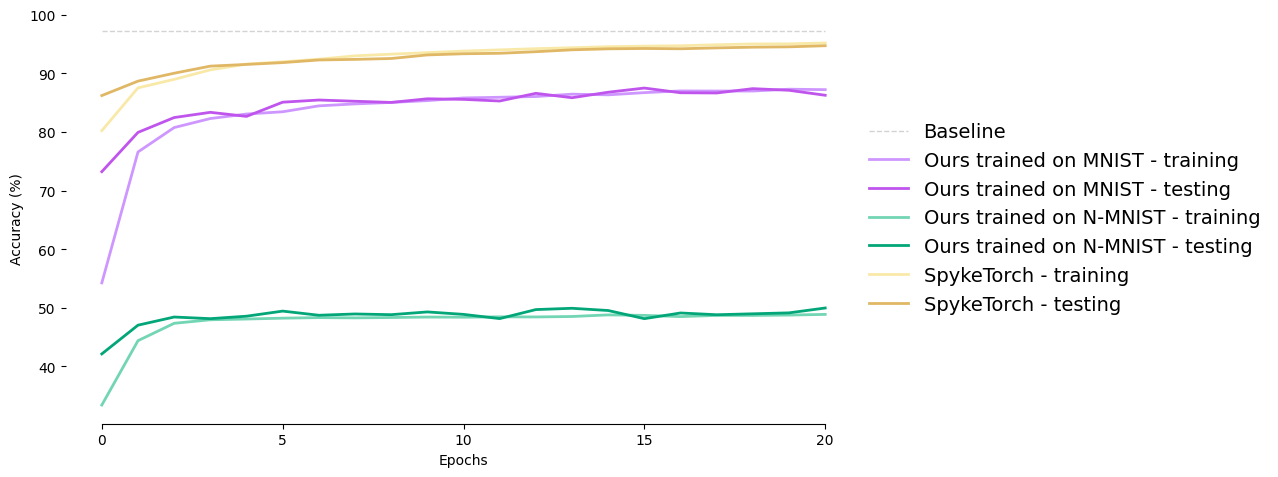

In [22]:
plotting.get_final_results(['../runs/experiment_1', '../runs/experiment_2', '../runs/experiment_3'])